# Reflection Agent

https://github.com/kyopark2014/llm-agent/blob/main/reflection-agent.md

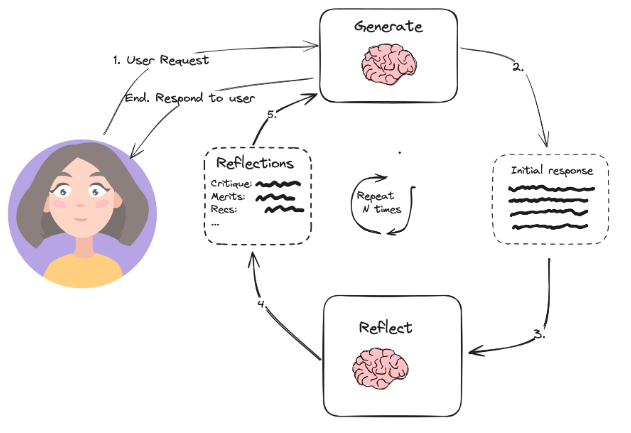

In [2]:
import boto3

In [3]:
!pip3 install langchain-aws langchain-community langchain --quiet

In [4]:
from botocore.config import Config
from langchain_aws import ChatBedrock
bedrock_region = 'us-east-1'
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=bedrock_region,
    config=Config(
        retries = {
            'max_attempts': 30
        }            
    )
)

HUMAN_PROMPT = "\n\nHuman:"
AI_PROMPT = "\n\nAssistant:"
maxOutputTokens = 4096
parameters = {
    "max_tokens":maxOutputTokens,     
    "temperature":0.1,
    "top_k":250,
    "top_p":0.9,
    "stop_sequences": [HUMAN_PROMPT]
}    
chat = ChatBedrock(   
    model_id=modelId,
    client=boto3_bedrock, 
    model_kwargs=parameters,
)

In [5]:
from langchain.memory import ConversationBufferWindowMemory
memory_chain = ConversationBufferWindowMemory(memory_key="chat_history", output_key='answer', return_messages=True, k=10)

In [19]:
from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate

def general_conversation(chat, query):
    system = (
"""다음은 Human과 AI의 친근한 대화입니다. AI는 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다. 
AI의 이름은 서연이고, Emoji 없이 가능한 한국어로 답변하세요. 또한, 한자는 한국어로 변환합니다."""
    )
    human = """{input}"""
    
    prompt = ChatPromptTemplate.from_messages([("system", system), MessagesPlaceholder(variable_name="history"), ("human", human)])
    print('prompt: ', prompt)
    
    chain = prompt | chat
        
    history = memory_chain.load_memory_variables({})["chat_history"]
    print('memory_chain: ', history)
                
    try: 
        stream = chain.invoke(
            {
                "history": history,
                "input": query,
            }
        )
        
        print('stream: ', stream)        
        usage = stream.response_metadata['usage']
        print('prompt_tokens: ', usage['prompt_tokens'])
        print('completion_tokens: ', usage['completion_tokens'])
        print('total_tokens: ', usage['total_tokens'])
        msg = stream.content
        
    except Exception:
        err_msg = traceback.format_exc()
        print('error message: ', err_msg)        
            
        raise Exception ("Not able to request to LLM")
    
    return msg

In [7]:
text = "여행하고 싶어"
msg = general_conversation(chat, text)    
msg

prompt:  input_variables=['history', 'input'] input_types={'history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='다음은 Human과 AI의 친근한 대화입니다. AI는 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다. \nAI의 이름은 서연이고, Emoji 없이 가능한 한국어로 답변하세요. 또한, 한자는 한국어로 변환합니다.<|eot_id|>')), MessagesPlaceholder(variable_name='history'), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))]
memory_chain:  []
stream:  content='여행은 정말 좋은 경험이 될 수 있습니다. 새로운 장소를 방문하고 다른 문화를 체험하면서 시야를 넓힐 수 있죠. 어디를 가고 싶으신가요? 국내 여행을 원하시나요, 아니면 해외 여행을 하고 싶으신가요? 예산과 시간, 관심사에 따라 다양한 옵션이 있습니다. 구체적인 계획을 세우면 여행 준비를 더 잘할 수 있을 것 같네요. 여행지에 대해 더 자세히 말씀해 주시면 적절한 조언을 드리겠습니다.' additional_kwargs=

'여행은 정말 좋은 경험이 될 수 있습니다. 새로운 장소를 방문하고 다른 문화를 체험하면서 시야를 넓힐 수 있죠. 어디를 가고 싶으신가요? 국내 여행을 원하시나요, 아니면 해외 여행을 하고 싶으신가요? 예산과 시간, 관심사에 따라 다양한 옵션이 있습니다. 구체적인 계획을 세우면 여행 준비를 더 잘할 수 있을 것 같네요. 여행지에 대해 더 자세히 말씀해 주시면 적절한 조언을 드리겠습니다.'

## Tavily Search

In [8]:
import getpass

api_key = getpass.getpass("Password:")

Password: ········


In [10]:
import os

In [11]:
os.environ["TAVILY_API_KEY"] = api_key

In [13]:
!pip install -U langchain-community tavily-python --quiet

In [14]:
from langchain_community.retrievers import TavilySearchAPIRetriever

retriever = TavilySearchAPIRetriever(k=3)

retriever.invoke("강남 맛집은?")

[Document(page_content='1. 강남역 맛집 : 신도세기. 자주 갔었는데 여길 왜 여태 기록 안해놨지?;; 강남역 김치찌개 맛집 신도세기~ 저녁엔 고기먹고나면 볶아먹는 철판 볶음밥도 맛있는데 점심엔 걍 무조건 돼지고기 많이 들어간 김치찜이나 김치찌개로 간다!! 부대찌개도 있는데 난 그것보단 고기랑 김치 듬뿍 찌개가 ...', metadata={'title': '강남역 맛집 내돈내산 14군데 모음 (3탄) : 네이버 블로그', 'source': 'https://m.blog.naver.com/twin_couple/222831691893', 'score': 0.98809, 'images': None}),
 Document(page_content='점심 시간에 방문하기 좋은 강남역 맛집. 매일 직송하는 좋은 한우 등심을 맛볼 수 있는 곳으로 평양냉면, 설화등심 꽃등심 전문점으로 벽제갈비에서 직영하고 있습니다. 싱싱한 육회 및 전골요리와 한우특양탕도 인기입니다. 그릇. 강남역주변에서 직장인들이 ...', metadata={'title': '강남 직장인이 뽑은 찐 강남역 맛집 25곳 | 식신,맛집추천', 'source': 'https://www.siksinhot.com/toplists/best/101767_gangnam', 'score': 0.98332, 'images': None}),
 Document(page_content='Pho vi cay, 매운 쪽갈비 쌀국수, 매운 우삽겹 쌀국수, 우삼겹 쌀국수\n11014\n4\n9\n2801\n1\n5\n라브리크 에그 모닝밀, 라브리크 버터밀, 머쉬룸 에그 샌드위치\n2893\n0\n1\n런치오마카세, 디너오마카세\n1317\n0\n3\nMamas Signature, Ricotta Cheese Salad, Beef Eggplant Panini, Club Sandwich, Green Grape Juice\n62583\n235\n308\n69cm 계란말이, 석쇠불고기 1판, 바싹 튀긴 옛날 치킨, 해물김치피자전

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults
search = TavilySearchResults(k=5)
search.invoke("강남 맛집은?")

[{'url': 'https://www.siksinhot.com/toplists/best/101767_gangnam',
  'content': '점심 시간에 방문하기 좋은 강남역 맛집. 매일 직송하는 좋은 한우 등심을 맛볼 수 있는 곳으로 평양냉면, 설화등심 꽃등심 전문점으로 벽제갈비에서 직영하고 있습니다. 싱싱한 육회 및 전골요리와 한우특양탕도 인기입니다. 그릇. 강남역주변에서 직장인들이 ...'},
 {'url': 'https://m.blog.naver.com/twin_couple/222831691893',
  'content': '1. 강남역 맛집 : 신도세기. 자주 갔었는데 여길 왜 여태 기록 안해놨지?;; 강남역 김치찌개 맛집 신도세기~ 저녁엔 고기먹고나면 볶아먹는 철판 볶음밥도 맛있는데 점심엔 걍 무조건 돼지고기 많이 들어간 김치찜이나 김치찌개로 간다!! 부대찌개도 있는데 난 그것보단 고기랑 김치 듬뿍 찌개가 ...'},
 {'url': 'https://www.siksinhot.com/taste?upHpAreaId=9&hpAreaId=33',
  'content': 'Pho vi cay, 매운 쪽갈비 쌀국수, 매운 우삽겹 쌀국수, 우삼겹 쌀국수\n11014\n4\n9\n2801\n1\n5\n라브리크 에그 모닝밀, 라브리크 버터밀, 머쉬룸 에그 샌드위치\n2893\n0\n1\n런치오마카세, 디너오마카세\n1317\n0\n3\nMamas Signature, Ricotta Cheese Salad, Beef Eggplant Panini, Club Sandwich, Green Grape Juice\n62583\n235\n308\n69cm 계란말이, 석쇠불고기 1판, 바싹 튀긴 옛날 치킨, 해물김치피자전, 얼큰한 해물 부추전, 통마늘 후라이드치킨, 악바리 후라이드치킨, 악바리 매운 양념치킨, 치킨 쫄깃 떡볶이, 닭모래집 후라이드\n54752\n188\n134\n깻잎 불고기 사라다를 듬뿍 올려먹는 맛있는 밥, 매콤달콤 닭고기튀김, 숯불구이반반, 스튜우동(고로케)

In [17]:
langsmith_api_key = getpass.getpass("Password:")

Password: ········


In [18]:
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Agent-Reflection"

In [ ]:
system = (
"""You are an essay assistant tasked with writing excellent 5-paragraph essays.
Generate the best essay possible for the user's request.
If the user provides critique, respond with a revised version of your previous attempts.
"""
)
human = """{input}"""
    
prompt = ChatPromptTemplate.from_messages([("system", system), MessagesPlaceholder(variable_name="history"), ("human", human)])
print('prompt: ', prompt)
    
chain = prompt | chat
        
history = memory_chain.load_memory_variables({})["chat_history"]
print('memory_chain: ', history)
                
try: 
        stream = chain.invoke(
            {
                "history": history,
                "input": query,
            }
        )
        
        print('stream: ', stream)        
        usage = stream.response_metadata['usage']
        print('prompt_tokens: ', usage['prompt_tokens'])
        print('completion_tokens: ', usage['completion_tokens'])
        print('total_tokens: ', usage['total_tokens'])
        msg = stream.content
        
    except Exception:
        err_msg = traceback.format_exc()
        print('error message: ', err_msg)        
            
        raise Exception ("Not able to request to LLM")
    
    return msg

In [21]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an essay assistant tasked with writing excellent 5-paragraph essays."
            " Generate the best essay possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
chain = prompt | chat

essay = ""
request = HumanMessage(
    content="Write an essay on why the little prince is relevant in modern childhood"
)
for chunk in chain.stream({"messages": [request]}):
    print(chunk.content, end="")
    essay += chunk.content

Here is a 5-paragraph essay on why the book The Little Prince by Antoine de Saint-Exupéry is relevant for modern childhood:

The Little Prince, a beloved novella by Antoine de Saint-Exupéry, has captured the hearts of readers across generations since its publication in 1943. Despite being a simple tale about a young prince from a tiny asteroid, this book holds profound wisdom and insights that resonate deeply with the experiences of modern childhood.

One of the central themes of The Little Prince is the importance of preserving a sense of wonder and imagination in the face of an increasingly cynical and materialistic world. The little prince's journey across different planets symbolizes the journey of growing up, where he encounters adults who have lost touch with the simple joys and curiosities of childhood. This serves as a poignant reminder for children today, who are often bombarded with technology, social media, and societal pressures that can stifle their natural inclination tow

## Reflect

In [24]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | chat

In [25]:
reflection = ""
for chunk in reflect.stream({"messages": [request, HumanMessage(content=essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content

Thank you for sharing your essay on the relevance of The Little Prince for modern childhood. Here are some critiques and recommendations:

Strengths:
- Well-structured with a clear introduction, body paragraphs addressing different themes, and a conclusion.
- Good use of examples and references from the book to support your points.
- Effectively highlights the book's themes of imagination, relationships, critical thinking, and questioning societal norms as relevant for modern children.
- Engaging writing style that captures the essence of the book's message.

Recommendations:
1. Length and depth: While the essay covers several important themes, it could benefit from additional depth and analysis. Consider expanding on each theme with more specific examples from the book and connecting them more explicitly to the challenges faced by modern children.

2. Personal connections: The essay could be strengthened by incorporating personal anecdotes or experiences that illustrate how the book's

## Repeat

In [26]:
for chunk in chain.stream({"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}):
    print(chunk.content, end="")

Thank you for the thoughtful feedback and recommendations. I have revised the essay to incorporate your suggestions:

The Little Prince, a timeless novella by Antoine de Saint-Exupéry, has captured the imaginations of readers young and old for generations. As a child, this simple yet profound tale about a young prince from a tiny asteroid left an indelible mark on me, shaping my perspective on life in ways that remain relevant even today.

At its core, The Little Prince serves as a poignant reminder to preserve the sense of wonder and curiosity that is so natural in childhood. In an age where children are constantly bombarded with technology, social media, and societal pressures, it's easy for their imaginations to become stifled. I vividly remember how the prince's encounters with the adults on different planets, who had lost touch with the simple joys of life, resonated with me. It inspired me to hold onto my childlike ability to find magic in the mundane, a quality that has enriched

## Define graph

In [29]:
from typing import List, Sequence

from langgraph.graph import END, MessageGraph, START


async def generation_node(state: Sequence[BaseMessage]):
    return await chain.ainvoke({"messages": state})


async def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [messages[0]] + [
        cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = await reflect.ainvoke({"messages": translated})
    # We treat the output of this as human feedback for the generator
    return HumanMessage(content=res.content)


builder = MessageGraph()
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


def should_continue(state: List[BaseMessage]):
    if len(state) > 6:
        # End after 3 iterations
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
graph = builder.compile()

In [30]:
async for event in graph.astream(
    [
        HumanMessage(
            content="Generate an essay on the topicality of The Little Prince and its message in modern life"
        )
    ],
):
    print(event)
    print("---")

{'generate': AIMessage(content="Here is a 5-paragraph essay on the topicality of The Little Prince and its message in modern life:\n\nThe Little Prince by Antoine de Saint-Exupéry is a beloved classic of children's literature that has transcended generations with its timeless and universal messages. Despite being published over 75 years ago, the story remains highly relevant and topical in today's fast-paced, materialistic world. Its profound insights into what truly matters in life continue to resonate deeply with modern readers of all ages.\n\nOne of the core messages of The Little Prince is the importance of seeing beyond the superficial and appreciating the intangible essentials in life. The little prince's encounters with the vain man, the drunkard, and others on the tiny planets represent the emptiness and folly of certain behaviors and attitudes so prevalent in society today. His deep bond with the rose and later the fox teach him the true meaning of love, friendship, and respon

In [31]:
ChatPromptTemplate.from_messages(event[END]).pretty_print()

KeyError: '__end__'